In [84]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from IPython import display

import fnmatch

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [85]:
data_dir = pathlib.Path(r"D:\magistracy\diplom\records_cut")
filenames = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if(file.endswith(".wav")):
            filenames.append(os.path.join(root,file))

In [86]:
notes = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Notes:', notes)

Notes: ['A' 'A#' 'B' 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G' 'G#']


In [87]:
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/notes[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 30828
Number of examples per label: 2318
Example file tensor: tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\D#\\en027a_55.wav', shape=(), dtype=string)


In [88]:
# Для удобства разбиения выборки на тренировочную, тестовую и валидационную возьмем только 28000 файлов, 
# которые разобьем в соотношении 70:20:10 

filenames = filenames[:28000]

train_files = filenames[:19600]
val_files = filenames[19600: 19600 + 5600]
test_files = filenames[-2800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 19600
Validation set size 5600
Test set size 2800


In [89]:
# После разделения изначальных аудио-файлов на ноты все получившиеся записи стали моно-записями
test_file = tf.io.read_file(filenames[0])
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([11506, 1])

In [90]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary) # возвращает WAV-кодированные как Тензор и частотой дискретизации.
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Примечание. Здесь будет использоваться индексирование вместо распаковки кортежей, 
  # чтобы это работало на графике TensorFlow.
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [91]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

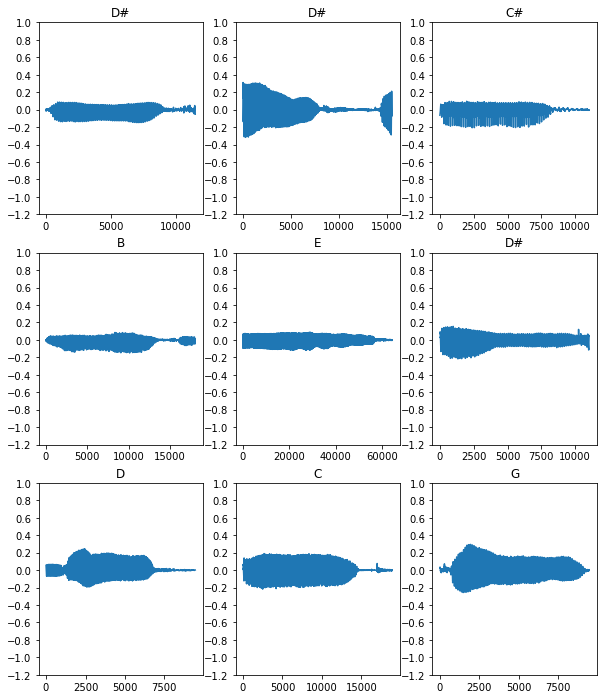

In [92]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [143]:
def get_spectrogram(waveform):
    
    input_len = 1025*15
    waveform = waveform[:input_len]
    # Заполнение нулями для файлов с длиной, меньше input_len
    #zero_padding = tf.zeros([1024*15] - tf.shape(waveform), dtype=tf.float32)
    # Объедините звук с заполнением, чтобы все аудиоклипы были одинаковой длины.
    waveform = tf.cast(waveform, tf.float32)
    #equal_length = tf.concat([waveform, zero_padding], 0)
    equal_length = waveform
    spectrogram = tf.signal.stft(equal_length, frame_length=2048, frame_step=1024,pad_end=True)
    spectrogram = tf.abs(spectrogram)

    return spectrogram



In [144]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)
    spectrogram = get_spectrogram_15(spectrogram)  

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=44100))

Label: D#
Waveform shape: (11506,)
Spectrogram shape: (15, 1025)
Audio playback


C:\Users\belas\AppData\Local\Temp/ipykernel_10144/2012431338.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


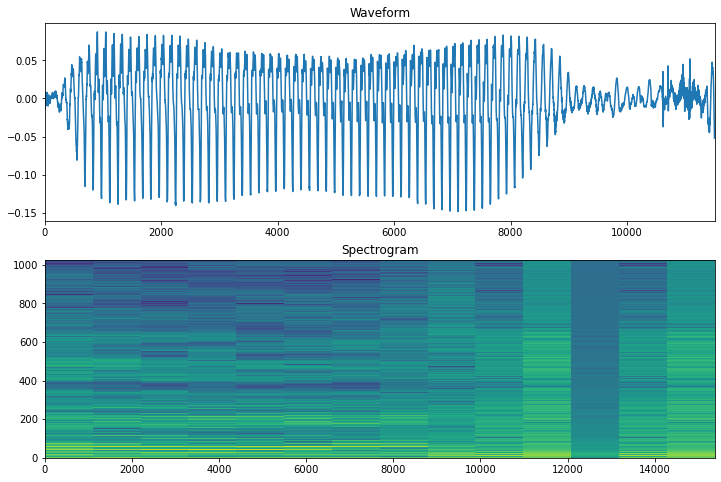

In [145]:
def plot_spectrogram(spectrogram, ax):
  # Преобразуем в частоты для логарифмической шкалы и транспонируем так, чтобы время
  # было представлено на оси x (столбцы). Эпсилон добавляется, чтобы избежать нуля.
  log_spec = np.log(spectrogram.T+np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, waveform.shape[0]])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [182]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == notes)
    return spectrogram, label_id

def get_spectrogram_and_label_id_15(spectrogram, label_id):
    spec_length = len(spectrogram)
    if spec_length<15:
        for k in range(15-spec_length):
            spectrogram = tf.concat([spectrogram, spectrogram[spec_length-1]], 0)
    elif spec_length>15:
        spectrogram = spectrogram[0:15]

    return spectrogram, label_id

In [239]:
spectrogram_ds = waveform_ds.map(map_func=get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

count = 0
for a, _ in waveform_ds:
    count += 1
    if a.shape[0]==0:
        print(count, a.shape[0])
print()
count = 0
for a, _ in spectrogram_ds:
    count += 1
    if a.shape[0]==0:
        print(count, a.shape[0])
print()
spectrogram_ds = spectrogram_ds.map(lambda x, y: get_spectrogram_and_label_id_15(x,y))
spectrogram_ds = spectrogram_ds.map(lambda x, y: get_spectrogram_and_label_id_15(x,y))
count = 0
count1 = 0
for a, _ in spectrogram_ds:
    count += 1
    if a.shape[0]<15:
        print(count, a.shape[0])
        count1 += 1
print(count1)

1171 0
2199 0
4355 0
4425 0
8201 0
9690 0
12707 0
14965 0
17485 0
19349 0

1171 0
2199 0
4355 0
4425 0
8201 0
9690 0
12707 0
14965 0
17485 0
19349 0

491 9
1067 8
1171 0
1492 9
1713 9
1814 9
2165 9
2199 0
2226 9
2347 9
3485 8
3785 9
4247 9
4355 0
4425 0
4451 9
4473 9
4860 9
4877 9
5864 9
5925 9
6635 9
6777 8
7057 9
7316 9
7974 9
7992 9
8201 0
8231 9
9112 9
9546 9
9690 0
9745 9
10431 9
10512 9
11946 8
12707 0
12869 9
13306 9
13433 9
13617 9
14078 9
14498 9
14701 8
14965 0
15599 9
15731 9
16243 9
16932 9
17199 9
17239 9
17273 9
17485 0
17490 9
18467 9
18911 9
19237 9
19349 0
58


C:\Users\belas\AppData\Local\Temp/ipykernel_10144/2012431338.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


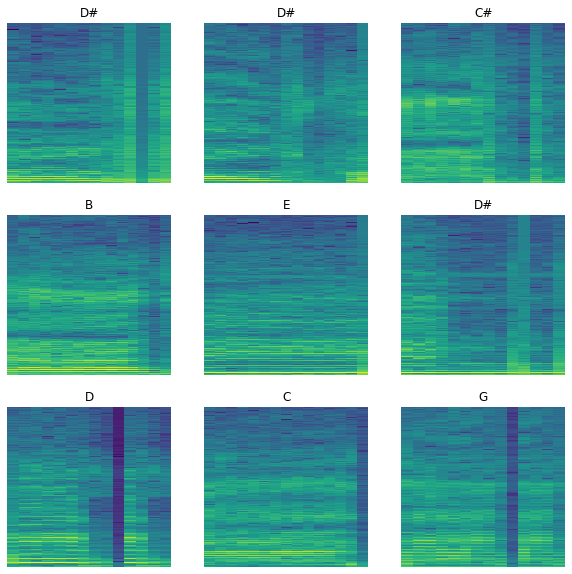

In [151]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    spectrogram = get_spectrogram_15(spectrogram)  
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(notes[label_id.numpy()])
    ax.axis('off')

plt.show()

In [152]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(map_func=get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
    return output_ds

In [153]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [101]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [80]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [81]:
val_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1025, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [82]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)

def create_model():
    inputs = layers.Input(shape = (15, 1025, 1), name = "inputs")
    x = layers.Flatten()(inputs)
    x = layers.Dense(512,activation = 'relu', name = "relu_1")(x)
    x = layers.Dense(512,activation = 'relu', name = "relu_2")(x)
    x = layers.Dense(512,activation = 'relu', name = "relu_3")(x)
    outputs = layers.Dense(12,activation = 'softmax', name = "dense_end")(x)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model
    

model = create_model()
model.summary()

Input shape: (12, 1025, 1)
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 15, 1025, 1)]     0         
                                                                 
 flatten_7 (Flatten)         (None, 15375)             0         
                                                                 
 relu_1 (Dense)              (None, 512)               7872512   
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 8,403,980
Trainabl

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Номер эпохи')
plt.ylabel('Значение штрафа')
plt.show()

In [ ]:
test_audio = []
test_labels = []

count = 0
for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true) * 100
print('Test set accuracy: ', test_acc, '%')

In [ ]:
p = model.predict(test_audio)
for idx, pp in enumerate(p[:3]):
    plt.bar(np.arange(0,12),pp, label = y_true[idx])

plt.xlabel('Значение')
plt.ylabel('Вероятность')
plt.title('Предсказание')
plt.xticks(np.arange(0,12)) # ['A' 'A#' 'B' 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G' 'G#']
plt.legend()

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 12))
sns.heatmap(confusion_mtx, xticklabels=notes, yticklabels=notes, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
sample_file = data_dir/'E/arpeg-CMaj-060BPM-leg_2.wav'
print('Sample file:', filenames[0])

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.bar(notes, prediction[0])
    t = 'Predictions for "'+ notes[label[0]]+'"'
    plt.title(t)
    plt.show()

In [ ]:
# Сохраняем модель
model.save(r"D:\magistracy\diplom\model\model.h5")